# Regresión logística

## Cargamos los datos

In [5]:
import pandas as pd
import numpy as np
from sklearn.utils import resample
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [6]:
df = pd.read_csv('df_train.csv')
df

,id,LoanNr_ChkDgt,Name,City,State,Bank,BankState,ApprovalDate,ApprovalFY,NoEmp,...,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,BalanceGross,Accept
0,bd9d6267ec5,1523195006,"P-SCAPE LAND DESIGN, LLC",NORTHFIELD,OH,CITIZENS BANK NATL ASSOC,RI,2005-11-01,2006,2,...,0,2,0,1,0.0,0.0,2005-12-31,8000.0,0.0,1
1,9eebf6d8098,1326365010,The Fresh & Healthy Catering C,CANTON,OH,"FIRSTMERIT BANK, N.A.",OH,2005-06-06,2005,2,...,1,2,1,1,0.0,0.0,2005-07-31,166000.0,0.0,1
2,83806858500,6179584001,AARON MASON & HOWE LLC,SAWYERWOOD,OH,"PNC BANK, NATIONAL ASSOCIATION",OH,2003-03-18,2003,2,...,4,2,1,2,1.0,0.0,2003-03-31,25000.0,0.0,1
3,a21ab9cb3af,8463493009,MID OHIO CAR WASH,COLUMBUS,OH,THE HUNTINGTON NATIONAL BANK,OH,1995-06-28,1995,2,...,0,0,1,0,0.0,0.0,1996-01-31,220100.0,0.0,1
4,883b5e5385e,3382225007,Bake N Brew LLC,Newark,OH,THE HUNTINGTON NATIONAL BANK,OH,2009-04-16,2009,0,...,0,0,0,1,0.0,0.0,2009-05-31,25000.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22830,4f9443d2a46,1573725008,"SIBILA RACE ENGINEERING, INC",MASSILLON,OH,CITIZENS BANK NATL ASSOC,RI,2005-12-09,2006,1,...,0,1,0,1,0.0,0.0,2005-12-31,70000.0,0.0,1
22831,798db2753a7,2011184008,ENVIRO SHIELD POWER WASHING,SPRINGBORO,OH,"PNC BANK, NATIONAL ASSOCIATION",OH,1998-04-27,1998,2,...,0,0,1,0,0.0,1.0,1998-05-31,30000.0,0.0,1
22832,ddb3c5e9bff,4082983001,"MAINLINE TRCK&TRAILR SRVC, INC",BEDFORD,OH,GROWTH CAPITAL CORP.,OH,1990-05-09,1990,16,...,6,10,1,0,0.0,0.0,1991-02-13,92000.0,0.0,1
22833,407200a5dfe,7783283010,TIN BOX STUDIO,CINCINNATI,OH,KEYBANK NATIONAL ASSOCIATION,OH,1994-11-10,1995,1,...,0,0,1,0,0.0,1.0,1995-01-31,20000.0,0.0,1


### SUBMUESTREO

In [7]:
# 2. Separar clases mayoritaria y minoritaria
df_majority = df[df["Accept"] == 1]  # Créditos aceptados (clase mayoritaria)
df_minority = df[df["Accept"] == 0]  # Créditos no aceptados (clase minoritaria)

In [8]:
# 3. Aplicar Submuestreo (undersampling)
df_majority_downsampled = resample(df_majority, 
                                   replace=False,  # Sin reemplazo
                                   n_samples=len(df_minority),  # Igualar cantidad de muestras
                                   random_state=42)  # Fijar semilla

In [9]:
# 4. Unir el dataset balanceado
df_balanced = pd.concat([df_majority_downsampled, df_minority])

In [10]:
# 5. Mezclar los datos para evitar sesgos
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

In [11]:
df.dtypes

id                    object
LoanNr_ChkDgt          int64
Name                  object
City                  object
State                 object
Bank                  object
BankState             object
ApprovalDate          object
ApprovalFY             int64
NoEmp                  int64
NewExist             float64
CreateJob              int64
RetainedJob            int64
FranchiseCode          int64
UrbanRural             int64
RevLineCr            float64
LowDoc               float64
DisbursementDate      object
DisbursementGross    float64
BalanceGross         float64
Accept                 int64
dtype: object

## Train and test splitting

In [12]:
df["BalanceGross"].unique()

array([     0.,   9111., 996262.])

In [13]:
# Eliminar filas con NaN en las columnas relevantes
columnas_relevantes = ['City', 'NoEmp', 'UrbanRural', 'NewExist', 'Accept']
df_balanced= df_balanced.dropna(subset=columnas_relevantes)
df_balanced = df_balanced.drop(columns=["id"])

df_balanced.head()

,LoanNr_ChkDgt,Name,City,State,Bank,BankState,ApprovalDate,ApprovalFY,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,BalanceGross,Accept
0,2271315002,"DAS Transportation, LLC",Greenwillow,OH,THE HUNTINGTON NATIONAL BANK,OH,2007-02-12,2007,5,1.0,0,1,0,1,0.0,0.0,2007-06-30,31000.0,0.0,0
1,2740965002,"Our Family Home, Inc.",COLUMBUS,OH,JPMORGAN CHASE BANK NATL ASSOC,IL,2007-10-03,2008,7,1.0,0,7,0,1,1.0,0.0,NaN,61461.0,0.0,1
2,3439346006,CALLAHAN CUTTING TOOLS INC,COLUMBUS,OH,THE HUNTINGTON NATIONAL BANK,OH,2008-09-25,2008,4,0.0,0,4,1,1,0.0,0.0,2008-09-30,50000.0,0.0,1
3,1563195000,"H2O Motion Oasis, LLC",Reynoldsburg,OH,"BUSINESS LOAN CENTER, LLC",FL,2005-12-02,2006,3,1.0,0,3,0,1,0.0,0.0,2005-12-31,25000.0,0.0,0
4,1687155001,LOVE PHOTOGRAPHY AND CUSTOM FR,WESTLAKE,OH,CITIZENS BANK NATL ASSOC,RI,2006-03-01,2006,2,0.0,0,2,0,1,0.0,0.0,2006-03-31,42000.0,0.0,1


In [14]:
# Seleccionar variables predictoras y la variable objetivo "Accept"
X = df_balanced[['City', 'NoEmp', 'UrbanRural', 'NewExist']] 
y = df_balanced['Accept']

# Convertir variables categóricas a dummies (City, State y UrbanRural)
X = pd.get_dummies(X, columns=['City', 'UrbanRural'], drop_first=True)

df_balanced

,LoanNr_ChkDgt,Name,City,State,Bank,BankState,ApprovalDate,ApprovalFY,NoEmp,NewExist,CreateJob,RetainedJob,FranchiseCode,UrbanRural,RevLineCr,LowDoc,DisbursementDate,DisbursementGross,BalanceGross,Accept
0,2271315002,"DAS Transportation, LLC",Greenwillow,OH,THE HUNTINGTON NATIONAL BANK,OH,2007-02-12,2007,5,1.0,0,1,0,1,0.0,0.0,2007-06-30,31000.0,0.0,0
1,2740965002,"Our Family Home, Inc.",COLUMBUS,OH,JPMORGAN CHASE BANK NATL ASSOC,IL,2007-10-03,2008,7,1.0,0,7,0,1,1.0,0.0,NaN,61461.0,0.0,1
2,3439346006,CALLAHAN CUTTING TOOLS INC,COLUMBUS,OH,THE HUNTINGTON NATIONAL BANK,OH,2008-09-25,2008,4,0.0,0,4,1,1,0.0,0.0,2008-09-30,50000.0,0.0,1
3,1563195000,"H2O Motion Oasis, LLC",Reynoldsburg,OH,"BUSINESS LOAN CENTER, LLC",FL,2005-12-02,2006,3,1.0,0,3,0,1,0.0,0.0,2005-12-31,25000.0,0.0,0
4,1687155001,LOVE PHOTOGRAPHY AND CUSTOM FR,WESTLAKE,OH,CITIZENS BANK NATL ASSOC,RI,2006-03-01,2006,2,0.0,0,2,0,1,0.0,0.0,2006-03-31,42000.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7657,2354885004,MarinkoHrnjak,Norton,OH,"PNC BANK, NATIONAL ASSOCIATION",DE,2007-03-26,2007,2,0.0,0,2,0,2,0.0,0.0,2007-05-31,35400.0,0.0,0
7658,2497055010,Paul S. Martin dba Elljaye Int,Powell,OH,THE HUNTINGTON NATIONAL BANK,OH,2007-06-06,2007,0,0.0,0,0,0,2,0.0,0.0,2007-06-30,25000.0,0.0,0
7659,2008785006,POWERCLEAN EQUIPMENT COMPANY,CLEVES,OH,KEYBANK NATIONAL ASSOCIATION,OH,2006-09-08,2006,4,1.0,0,4,0,1,1.0,0.0,2006-10-31,56000.0,0.0,1
7660,1467113006,DAVID BOYLE INC,NEW LEXINGTON,OH,THE PEOPLES NATIONAL BANK,OH,1982-12-20,1983,5,1.0,0,0,0,0,0.0,0.0,1983-02-02,190000.0,0.0,0


In [15]:
# 2. Dividir en Train y Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [16]:
# Normalizar características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
# 3. Definir el modelo
model = LogisticRegression(max_iter=1000)

In [22]:
# 4. Entrenar el modelo
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [23]:
# 5. Evaluar el modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.6175


In [25]:
# 6. Matriz de confusión y F-score
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_test, y_pred))

Confusion Matrix:
 [[1410  498]
 [ 967  955]]
Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.74      0.66      1908
           1       0.66      0.50      0.57      1922

    accuracy                           0.62      3830
   macro avg       0.63      0.62      0.61      3830
weighted avg       0.63      0.62      0.61      3830



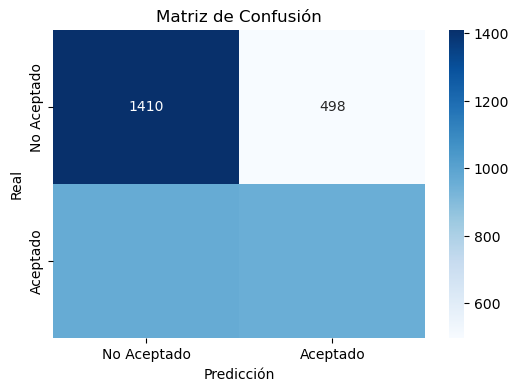

In [26]:
# Graficar matriz de confusión
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Aceptado", "Aceptado"], yticklabels=["No Aceptado", "Aceptado"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

In [ ]:
# 7. Curva ROC y AUC
y_probs = model.predict_proba(X_test)[:,1]  # Probabilidades para clase positiva
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.show()

print(f"AUC Score: {roc_auc:.4f}")

In [ ]:
# 8. Validación Cruzada con K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kfold_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')

print(f"K-Fold Accuracy Scores: {kfold_scores}")
print(f"Mean Accuracy: {kfold_scores.mean():.4f}")


### Hipotesis 3

In [ ]:
df['FranchiseCode'].unique()

In [ ]:
df['RevLineCr'].fillna(df['RevLineCr'].mean(), inplace=True)
df['LowDoc'].fillna(df['LowDoc'].mean(), inplace=True)

# Seleccionar variables predictoras y la variable objetivo "Accept"
X = df[['City', 'NoEmp', 'NewExist', 'UrbanRural', 'BalanceGross', 'DisbursementGross', 'FranchiseCode']] 
y = df['Accept']

# Convertir variables categóricas a dummies (City, State y UrbanRural)
X = pd.get_dummies(X, columns=['City', 'UrbanRural'], drop_first=True)

df

In [ ]:
# 2. Dividir en Train y Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)

In [ ]:
# Normalizar características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# 3. Definir el modelo
model = LogisticRegression(max_iter=6000, class_weight="balanced")

In [ ]:
# 4. Entrenar el modelo
model.fit(X_train, y_train)

In [ ]:
# 5. Evaluar el modelo
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

In [ ]:
# 6. Matriz de confusión y F-score
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)
print("Classification Report:\n", classification_report(y_test, y_pred))

In [ ]:
# Graficar matriz de confusión
plt.figure(figsize=(6,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["No Aceptado", "Aceptado"], yticklabels=["No Aceptado", "Aceptado"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.show()

In [ ]:
# 7. Curva ROC y AUC
y_probs = model.predict_proba(X_test)[:,1]  # Probabilidades para clase positiva
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC")
plt.legend()
plt.show()

print(f"AUC Score: {roc_auc:.4f}")

In [ ]:
# 8. Validación Cruzada con K-Fold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
kfold_scores = cross_val_score(model, X, y, cv=kf, scoring='accuracy')

print(f"K-Fold Accuracy Scores: {kfold_scores}")
print(f"Mean Accuracy: {kfold_scores.mean():.4f}")